# IFI 8420 - Spring 2021
## Final Project
## German Credit

GermanCredit.csv is the dataset for this case study.

### Background
Money-lending has been around since the advent of money; it is perhaps the world’s second-oldest profession. The systematic evaluation of credit risk, though, is a relatively recent arrival, and lending was largely based on reputation and very incomplete data. Thomas Jefferson, the third President of the United States, was in debt throughout his life and unreliable in his debt payments, yet people continued to lend him money. It wasn’t until the beginning of the 20th century that the Retail Credit Company was founded to share information about credit. That company is now Equifax, one of the big three credit scoring agencies (the other two are Transunion and Experion).

Individual and local human judgment are now largely irrelevant to the credit reporting process. Credit agencies and other big financial institutions extending credit at the retail level collect huge amounts of data to predict whether defaults or other adverse events will occur, based on numerous customer and transaction information.

### Data
This case deals with an early stage of the historical transition to predictive modeling, in which humans were employed to label records as either good or poor credit. The German Credit dataset2 has 30 variables and 1000 records, each record being a prior applicant for credit. Each applicant was rated as “good credit” (700 cases) or “bad credit” (300 cases). New applicants for credit can also be evaluated on these 30 predictor variables and classified as a good or a bad credit risk based on the predictor values.


The consequences of misclassification have been assessed as follows: The costs of a false positive (incorrectly saying that an applicant is a good credit risk) outweigh the benefits of a true positive (correctly saying that an applicant is a good credit risk) by a factor of 5. The opportunity cost table was derived from the average net profit per loan. Because decision makers are used to thinking of their decision in terms of net profits, we use these tables in assessing the performance of the various models.


In [1]:
! pip install pandas-profiling

In [2]:
%matplotlib inline
import warnings
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import confusion_matrix

from dmba import classificationSummary, gainsChart, liftChart


# Load the data

In [3]:
data = pd.read_csv('GermanCredit.csv', index_col='OBS#')
print(data.shape)
data.head()

(1000, 31)


CHK_ACCT  DURATION  HISTORY  NEW_CAR  USED_CAR  FURNITURE  RADIO/TV  \
OBS#                                                                        
1            0         6        4        0         0          0         1   
2            1        48        2        0         0          0         1   
3            3        12        4        0         0          0         0   
4            0        42        2        0         0          1         0   
5            0        24        3        1         0          0         0   

      EDUCATION  RETRAINING  AMOUNT  ...  AGE  OTHER_INSTALL  RENT  OWN_RES  \
OBS#                                 ...                                      
1             0           0    1169  ...   67              0     0        1   
2             0           0    5951  ...   22              0     0        1   
3             1           0    2096  ...   49              0     0        1   
4             0           0    7882  ...   45              0     0        0   
5             0           0    4870  ...   53              0     0        0   

      NUM_CREDITS  JOB  NUM_DEPENDENTS  TELEPHONE  FOREIGN  RESPONSE  
OBS#                                                                  
1               2    2               1          1        0         1  
2               1    2               1          0        0         0  
3               1    1               2          0        0         1  
4               1    2               2          0        0         1  
5               2    2               2          0        0         0  

[5 rows x 31 columns]

In [4]:
from pandas_profiling import ProfileReport
data.profile_report(explorative=True)

Summarize dataset:   0%|          | 0/45 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
data.RESPONSE.value_counts()

1    700
0    300
Name: RESPONSE, dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   CHK_ACCT          1000 non-null   int64
 1   DURATION          1000 non-null   int64
 2   HISTORY           1000 non-null   int64
 3   NEW_CAR           1000 non-null   int64
 4   USED_CAR          1000 non-null   int64
 5   FURNITURE         1000 non-null   int64
 6   RADIO/TV          1000 non-null   int64
 7   EDUCATION         1000 non-null   int64
 8   RETRAINING        1000 non-null   int64
 9   AMOUNT            1000 non-null   int64
 10  SAV_ACCT          1000 non-null   int64
 11  EMPLOYMENT        1000 non-null   int64
 12  INSTALL_RATE      1000 non-null   int64
 13  MALE_DIV          1000 non-null   int64
 14  MALE_SINGLE       1000 non-null   int64
 15  MALE_MAR_or_WID   1000 non-null   int64
 16  CO-APPLICANT      1000 non-null   int64
 17  GUARANTOR         1000 non-null  

In [7]:
data.columns

Index(['CHK_ACCT', 'DURATION', 'HISTORY', 'NEW_CAR', 'USED_CAR', 'FURNITURE',
       'RADIO/TV', 'EDUCATION', 'RETRAINING', 'AMOUNT', 'SAV_ACCT',
       'EMPLOYMENT', 'INSTALL_RATE', 'MALE_DIV', 'MALE_SINGLE',
       'MALE_MAR_or_WID', 'CO-APPLICANT', 'GUARANTOR', 'PRESENT_RESIDENT',
       'REAL_ESTATE', 'PROP_UNKN_NONE', 'AGE', 'OTHER_INSTALL', 'RENT',
       'OWN_RES', 'NUM_CREDITS', 'JOB', 'NUM_DEPENDENTS', 'TELEPHONE',
       'FOREIGN', 'RESPONSE'],
      dtype='object')

#### Note: The opportunity cost table and the average net profit table are represented in a way that is different to the way we define the confusion matrix in the book. We therefore define the two matrices here transposed. 

In [8]:
cost = pd.DataFrame([{'accept': 0, 'reject': 100}, {'accept': 500, 'reject': 0}], index=['good', 'bad'])
print('Opportunity cost table:\n', cost)
print()
gain = pd.DataFrame([{'accept': 100, 'reject': 0}, {'accept': -500, 'reject': 0}], index=['good', 'bad'])
print('Average net profit:\n', gain)

Opportunity cost table:
       accept  reject
good       0     100
bad      500       0

Average net profit:
       accept  reject
good     100       0
bad     -500       0


## Step 1. Analyze your data
Review the predictor variables and guess what their role in a credit decision might be.  Are there any surprises in the data?

In [9]:
# Group categorical columns based on information
categorical_columns = [column for column in data.columns if len(data[column].unique()) <= 5]
# print(categorical_columns)

financial_history = ['CHK_ACCT', 'HISTORY', 'SAV_ACCT', 'OTHER_INSTALL', 'NUM_CREDITS']
credit_information = ['INSTALL_RATE', ]
customer_information = ['EMPLOYMENT', 'MALE_DIV', 'MALE_SINGLE', 'MALE_MAR_or_WID', 'CO-APPLICANT', 'GUARANTOR', 
                      'PRESENT_RESIDENT', 'REAL_ESTATE', 'PROP_UNKN_NONE', 'RENT', 'OWN_RES', 'JOB',
                      'NUM_DEPENDENTS', 'TELEPHONE', 'FOREIGN']
purpose = ['NEW_CAR', 'USED_CAR', 'FURNITURE', 'RADIO/TV', 'EDUCATION', 'RETRAINING']

### Financial history
We can see that information about the financial situation has a strong impact on wether the bank assesses a customer as having good or bad credit. 

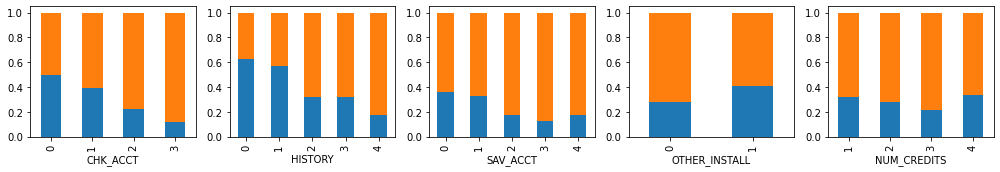

In [10]:
def stacked_barcharts(columns, ncols=5):
    nrows = 1 + (len(columns) - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows * 2.5))
    for i, column in enumerate(columns):
        # calculate pivot table
        pivot = pd.crosstab(data['RESPONSE'], data[column])
        # divide by column sums to get frequency per column
        freq = pivot.div(pivot.sum())
        # display as stacked bar chart with 100%
        ax = axes[i // 5, i % 5] if nrows > 1 else axes[i]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            freq.transpose().plot(kind='bar', ax=ax, stacked=True, legend=False)
    for i in range(len(columns), nrows * 5):
        ax = axes[i // 5, i % 5] if nrows > 1 else axes[i]
        fig.delaxes(ax)
    plt.tight_layout()

# good credit is shown in orange (700 cases), bad credit in blue (300 cases)
stacked_barcharts(financial_history)

### Credit information
- Increasing `INSTALL_RATE` (higher percentage of disposable income) leads to a slight reduction 
- Credits with longer duration have a higher ratio of 'bad' customers
- Credits with a larger amount tend to have a higher ratio of 'bad' customers

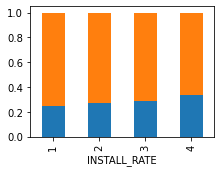

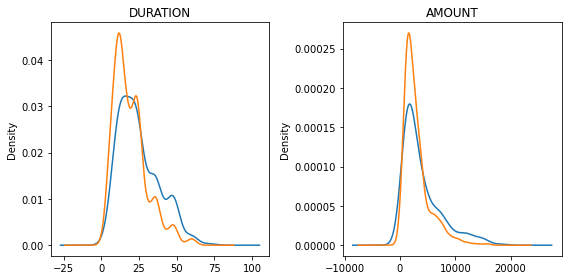

In [11]:
stacked_barcharts(credit_information)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
for i, column in enumerate(['DURATION', 'AMOUNT']):
    for response, group in data[['RESPONSE', column]].groupby('RESPONSE'):
        group[column].plot.density(ax=axes[i])
    axes[i].set_title(column)
plt.tight_layout()

#### Please explore the data more and make more data profiling visualizations.

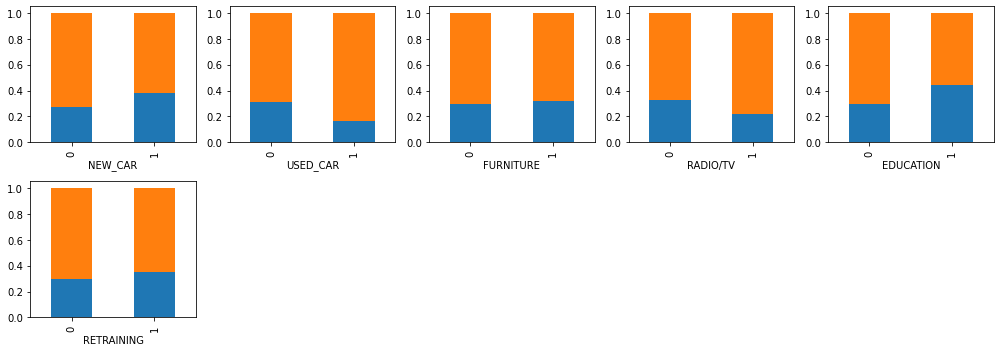

In [12]:
stacked_barcharts(purpose)

In [47]:
df = data
df = df.melt(['CHK_ACCT', 'HISTORY', 'SAV_ACCT', 'OTHER_INSTALL', 'NUM_CREDITS','INSTALL_RATE','EMPLOYMENT', 'MALE_DIV', 'MALE_SINGLE', 'MALE_MAR_or_WID', 'CO-APPLICANT', 'GUARANTOR', 
                      'PRESENT_RESIDENT', 'REAL_ESTATE', 'PROP_UNKN_NONE', 'RENT', 'OWN_RES', 'JOB',
                      'NUM_DEPENDENTS', 'TELEPHONE', 'FOREIGN','RESPONSE'], var_name='PURPOSE')
df = df[df.pop('value').eq(1)]
df.head()

CHK_ACCT  HISTORY  SAV_ACCT  OTHER_INSTALL  NUM_CREDITS  INSTALL_RATE  \
1004         0        3         0              0            2             3   
1009         1        4         0              0            2             4   
1010         1        2         0              0            1             3   
1013         0        4         0              0            2             4   
1014         0        2         0              0            1             2   

      EMPLOYMENT  MALE_DIV  MALE_SINGLE  MALE_MAR_or_WID  ...  REAL_ESTATE  \
1004           2         0            1                0  ...            0   
1009           0         0            0                1  ...            0   
1010           1         0            0                0  ...            0   
1013           4         0            1                0  ...            0   
1014           2         0            0                0  ...            0   

      PROP_UNKN_NONE  RENT  OWN_RES  JOB  NUM_DEPENDENTS  TELEPHONE  FOREIGN  \
1004               1     0        0    2               2          0        0   
1009               0     0        1    3               1          0        0   
1010               0     1        0    2               1          0        0   
1013               0     0        1    1               1          0        0   
1014               0     1        0    2               1          0        0   

      RESPONSE  PURPOSE  
1004         0  NEW_CAR  
1009         0  NEW_CAR  
1010         0  NEW_CAR  
1013         0  NEW_CAR  
1014         1  NEW_CAR  

[5 rows x 23 columns]

In [107]:
#financial_history = ['CHK_ACCT', 'HISTORY', 'SAV_ACCT', 'OTHER_INSTALL', 'NUM_CREDITS']
df2 = data
df2 = df2.melt(['DURATION', 'NEW_CAR', 'USED_CAR', 'FURNITURE',
       'RADIO/TV', 'EDUCATION', 'RETRAINING', 'AMOUNT',
       'EMPLOYMENT', 'INSTALL_RATE', 'MALE_DIV', 'MALE_SINGLE',
       'MALE_MAR_or_WID', 'CO-APPLICANT', 'GUARANTOR', 'PRESENT_RESIDENT',
       'REAL_ESTATE', 'PROP_UNKN_NONE', 'AGE', 'RENT',
       'OWN_RES', 'JOB', 'NUM_DEPENDENTS', 'TELEPHONE',
       'FOREIGN', 'RESPONSE'], var_name='financial_history')
df2 = df2[df2.pop('value').eq(1)]
df2.head()

DURATION  NEW_CAR  USED_CAR  FURNITURE  RADIO/TV  EDUCATION  RETRAINING  \
1         48        0         0          0         1          0           0   
7         36        0         1          0         0          0           0   
9         30        1         0          0         0          0           0   
10        12        1         0          0         0          0           0   
12        12        0         0          0         1          0           0   

    AMOUNT  EMPLOYMENT  INSTALL_RATE  ...  PROP_UNKN_NONE  AGE  RENT  OWN_RES  \
1     5951           2             2  ...               0   22     0        1   
7     6948           2             2  ...               0   35     1        0   
9     5234           0             4  ...               0   28     0        1   
10    1295           1             3  ...               0   25     1        0   
12    1567           2             1  ...               0   22     0        1   

    JOB  NUM_DEPENDENTS  TELEPHONE  FOREIGN  RESPONSE  financial_history  
1     2               1          0        0         0           CHK_ACCT  
7     3               1          1        0         1           CHK_ACCT  
9     3               1          0        0         0           CHK_ACCT  
10    2               1          0        0         0           CHK_ACCT  
12    2               1          1        0         1           CHK_ACCT  

[5 rows x 27 columns]

In [109]:
#customer_information = ['EMPLOYMENT', 'MALE_DIV', 'MALE_SINGLE', 'MALE_MAR_or_WID', 'CO-APPLICANT', 'GUARANTOR', 
#                      'PRESENT_RESIDENT', 'REAL_ESTATE', 'PROP_UNKN_NONE', 'RENT', 'OWN_RES', 'JOB',
#                      'NUM_DEPENDENTS', 'TELEPHONE', 'FOREIGN']
df3 = data
df3 = df3.melt(['CHK_ACCT', 'DURATION', 'HISTORY', 'NEW_CAR', 'USED_CAR', 'FURNITURE',
       'RADIO/TV', 'EDUCATION', 'RETRAINING', 'AMOUNT', 'SAV_ACCT', 'INSTALL_RATE',
        'AGE', 'OTHER_INSTALL','NUM_CREDITS','RESPONSE'], var_name='customer_information')
df3 = df3[df3.pop('value').eq(1)]
df3.head()

CHK_ACCT  DURATION  HISTORY  NEW_CAR  USED_CAR  FURNITURE  RADIO/TV  \
10         1        12        2        1         0          0         0   
11         0        48        2        0         0          0         0   
17         0        30        0        0         0          0         0   
22         0        10        4        1         0          0         0   
23         1        12        4        0         1          0         0   

    EDUCATION  RETRAINING  AMOUNT  SAV_ACCT  INSTALL_RATE  AGE  OTHER_INSTALL  \
10          0           0    1295         0             3   25              0   
11          0           1    4308         0             3   24              0   
17          0           1    8072         4             2   25              1   
22          0           0    2241         0             1   48              0   
23          0           0    1804         1             3   44              0   

    NUM_CREDITS  RESPONSE customer_information  
10            1         0           EMPLOYMENT  
11            1         0           EMPLOYMENT  
17            3         1           EMPLOYMENT  
22            2         1           EMPLOYMENT  
23            1         1           EMPLOYMENT

In [115]:
#credit_information = ['INSTALL_RATE', ]
df4 = data
df4 = df4.melt(['CHK_ACCT', 'DURATION', 'HISTORY', 'NEW_CAR', 'USED_CAR', 'FURNITURE',
       'RADIO/TV', 'EDUCATION', 'RETRAINING', 'AMOUNT', 'SAV_ACCT',
       'EMPLOYMENT', 'MALE_DIV', 'MALE_SINGLE',
       'MALE_MAR_or_WID', 'CO-APPLICANT', 'GUARANTOR', 'PRESENT_RESIDENT',
       'REAL_ESTATE', 'PROP_UNKN_NONE', 'AGE', 'OTHER_INSTALL', 'RENT',
       'OWN_RES', 'NUM_CREDITS', 'JOB', 'NUM_DEPENDENTS', 'TELEPHONE',
       'FOREIGN', 'RESPONSE'], var_name='credit_information')
df4 = df4[df4.pop('value').eq(1)]
df4.head()

CHK_ACCT  DURATION  HISTORY  NEW_CAR  USED_CAR  FURNITURE  RADIO/TV  \
12         1        12        2        0         0          0         1   
22         0        10        4        1         0          0         0   
25         0         6        2        0         0          1         0   
36         3        48        4        0         0          0         0   
43         0        30        4        0         1          0         0   

    EDUCATION  RETRAINING  AMOUNT  ...  OTHER_INSTALL  RENT  OWN_RES  \
12          0           0    1567  ...              0     0        1   
22          0           0    2241  ...              0     1        0   
25          0           0    1374  ...              1     0        1   
36          1           0    6110  ...              1     0        0   
43          0           0    6187  ...              0     1        0   

    NUM_CREDITS  JOB  NUM_DEPENDENTS  TELEPHONE  FOREIGN  RESPONSE  \
12            1    2               1          1        0         1   
22            2    1               2          0        1         1   
25            1    1               1          1        0         1   
36            1    2               1          1        0         1   
43            2    2               1          0        0         1   

    credit_information  
12        INSTALL_RATE  
22        INSTALL_RATE  
25        INSTALL_RATE  
36        INSTALL_RATE  
43        INSTALL_RATE  

[5 rows x 31 columns]

<AxesSubplot:xlabel='PURPOSE', ylabel='Count'>

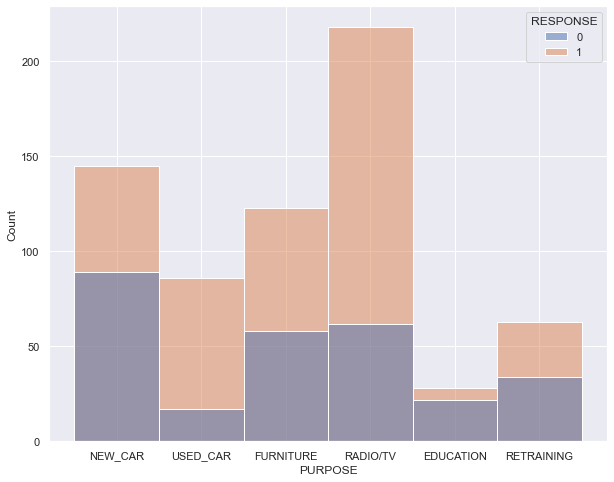

In [59]:
# Import seaborn
import seaborn as sns
f, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data=df, x="PURPOSE",hue='RESPONSE', ax=ax)

<AxesSubplot:xlabel='financial_history', ylabel='Count'>

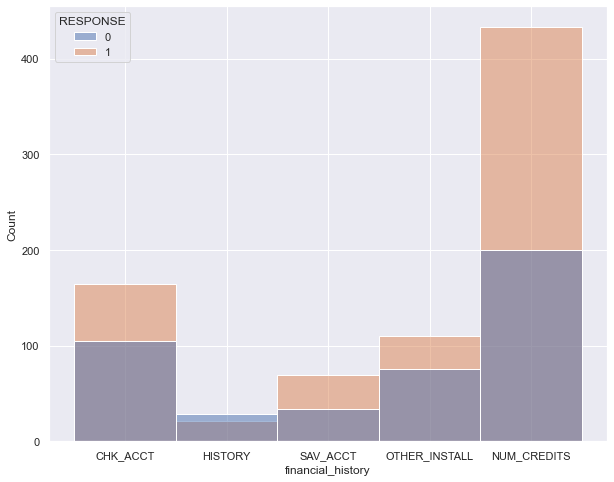

In [108]:
f, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data=df2, x="financial_history",hue='RESPONSE', ax=ax)

<AxesSubplot:xlabel='customer_information', ylabel='Count'>

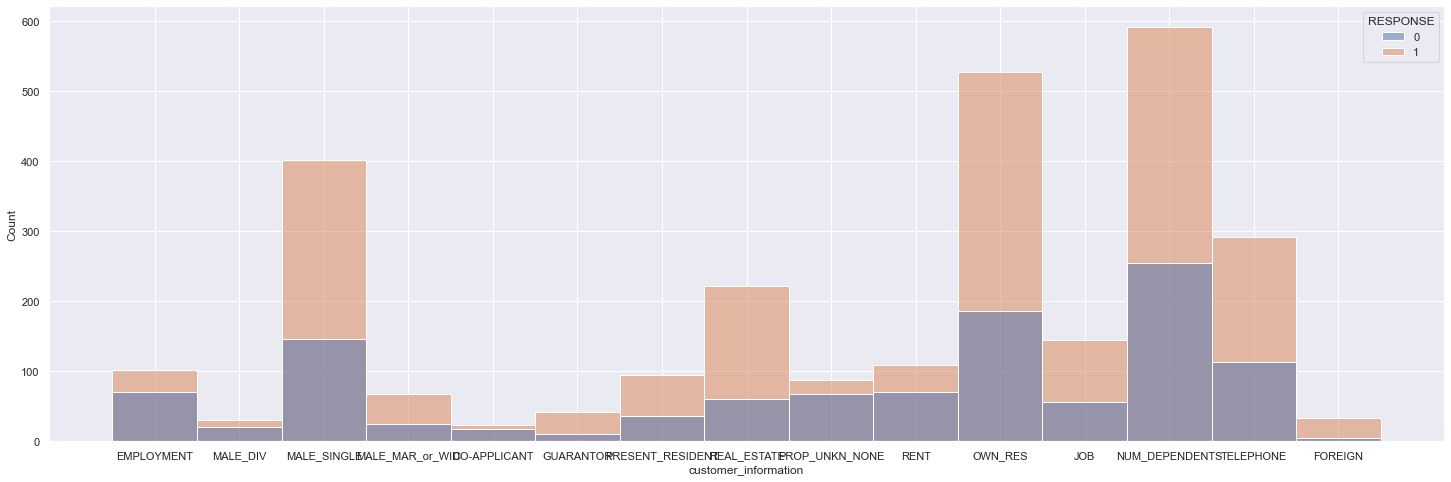

In [114]:
f, ax = plt.subplots(figsize=(25, 8))
sns.histplot(data=df3, x="customer_information",hue='RESPONSE', ax=ax)

<AxesSubplot:xlabel='credit_information', ylabel='Count'>

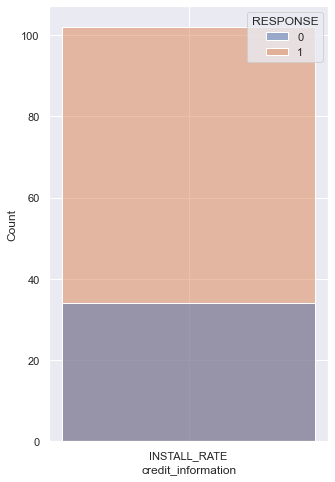

In [117]:
f, ax = plt.subplots(figsize=(5, 8))
sns.histplot(data=df4, x="credit_information",hue='RESPONSE', ax=ax)

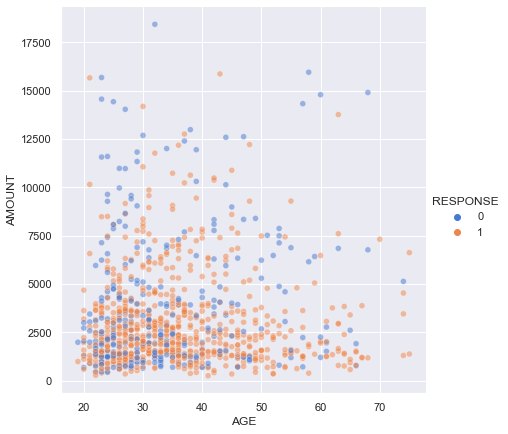

In [15]:
sns.relplot(x="AGE", y="AMOUNT", hue="RESPONSE",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=data)

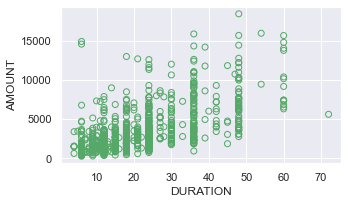

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 3)

ax.scatter(data.DURATION, data.AMOUNT, color='C2', facecolor='none')
plt.xlabel('DURATION')
plt.ylabel('AMOUNT')

plt.tight_layout()
plt.show()

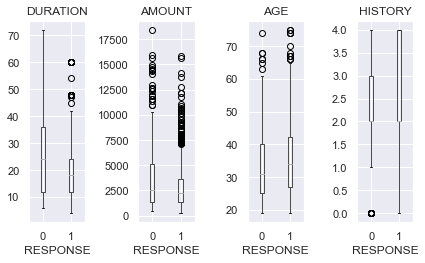

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=4)
data.boxplot(column='DURATION', by='RESPONSE', ax=axes[0])
data.boxplot(column='AMOUNT', by='RESPONSE', ax=axes[1])
data.boxplot(column='AGE', by='RESPONSE', ax=axes[2])
data.boxplot(column='HISTORY', by='RESPONSE', ax=axes[3])
for ax in axes:
    ax.set_xlabel('RESPONSE')
plt.suptitle('')  # Suppress the overall title
plt.tight_layout()  # Increase the separation between the plots

plt.show()

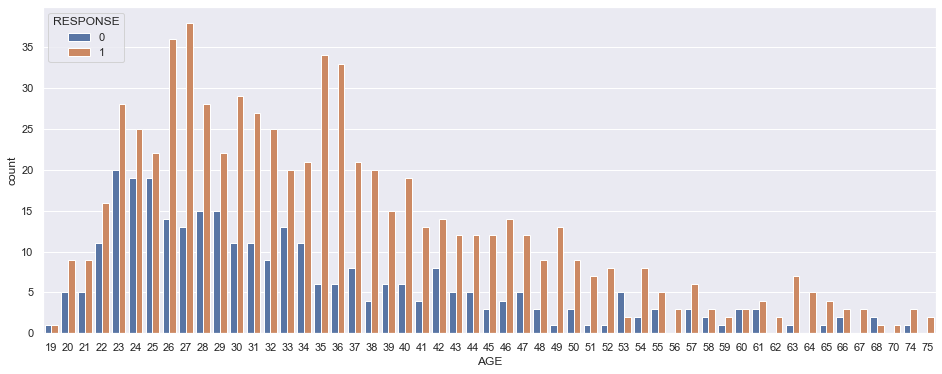

In [18]:
sns.color_palette("mako", as_cmap=True)
plt.figure(figsize=(16, 6))
sns_plot = sns.countplot(x='AGE',hue='RESPONSE',data=data)
fig = sns_plot.get_figure()
#fig.savefig("ClickDay.png")

<AxesSubplot:>

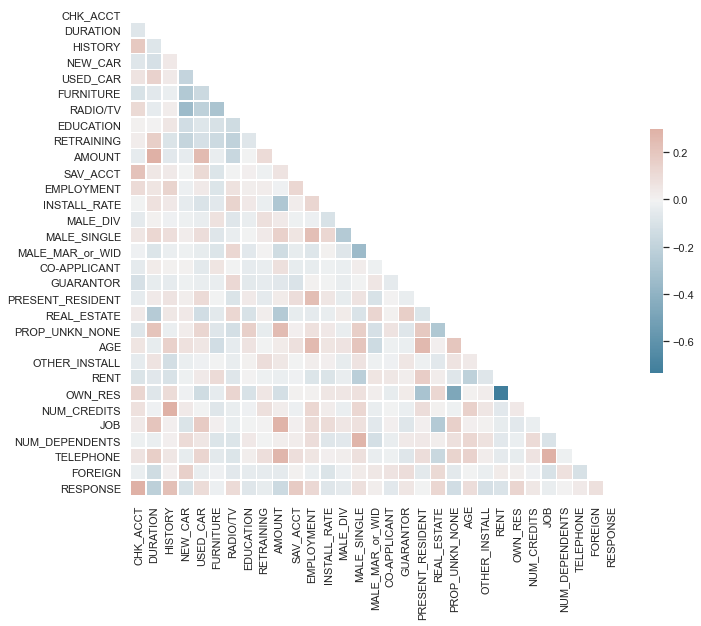

In [24]:
sns.set_theme(style="white")

corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:>

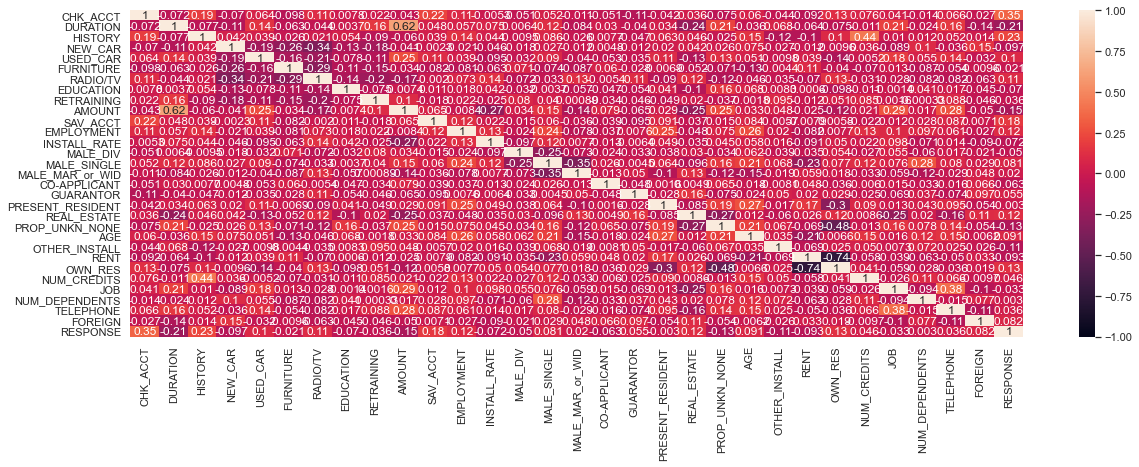

In [121]:
plt.figure(figsize=(20, 6))
corr = data.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,vmin=-1, vmax=1, annot=True)

In [118]:
correlation_mat = data.corr()

corr_pairs = correlation_mat.unstack()

print(corr_pairs)

CHK_ACCT  CHK_ACCT          1.000000
          DURATION         -0.072013
          HISTORY           0.192191
          NEW_CAR          -0.069559
          USED_CAR          0.064303
                              ...   
RESPONSE  JOB              -0.032735
          NUM_DEPENDENTS    0.003015
          TELEPHONE         0.036466
          FOREIGN           0.082079
          RESPONSE          1.000000
Length: 961, dtype: float64


In [ ]:
sns.pairplot(data=data, hue='RESPONSE');

## Step 2 Classification models
Divide the data into training and validation partitions, and develop classification models.


In [30]:
X = data.drop(columns=['RESPONSE'])
y = data['RESPONSE']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)#### Define helper functions

#### Define helper functions

In [31]:
def confusionMatrices(model, title):
    print(title + ' - training results')
    classificationSummary(train_y, model.predict(train_X))
    print(title + ' - validation results')
    valid_pred = model.predict(valid_X)
    classificationSummary(valid_y, valid_pred)
    return confusion_matrix(valid_y, valid_pred)

### Step 2.1 Logistic regression model

In [69]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)
logit_reg_confusion = confusionMatrices(logit_reg, 'Logistic regression')
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y, 
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

Logistic regression - training results
Confusion Matrix (Accuracy 0.7967)

       Prediction
Actual   0   1
     0 106  79
     1  43 372
Logistic regression - validation results
Confusion Matrix (Accuracy 0.7550)

       Prediction
Actual   0   1
     0  53  62
     1  36 249


#### Please try at least one more algorithm to compare the model performances.

In [33]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from dmba import gainsChart, liftChart
from sklearn.metrics import roc_curve, roc_auc_score
from dmba.metric import AIC_score
from sklearn import metrics

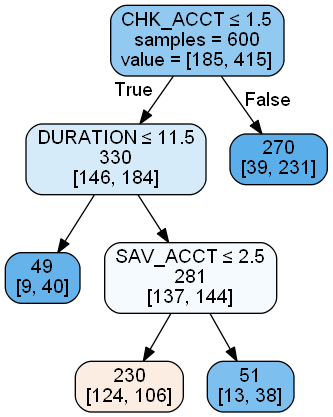

In [34]:
# Separate out predictors and outcome variable 
y = data['RESPONSE']
X = data.drop(columns=['RESPONSE'])
# partition the data into training (60%) and validation (40%) sets. use random_state=1 for reproducibility of results

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
# fit the tree

reducedClassTree = DecisionTreeClassifier(max_depth=7, min_samples_split=50, min_impurity_decrease=0.01, random_state=1)
reducedClassTree.fit(train_X, train_y)

plotDecisionTree(reducedClassTree, feature_names=train_X.columns)


In [35]:
# confusion matrices for training and validation sets
classificationSummary(train_y, reducedClassTree.predict(train_X))
classificationSummary(valid_y, reducedClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.7217)

       Prediction
Actual   0   1
     0 124  61
     1 106 309
Confusion Matrix (Accuracy 0.7175)

       Prediction
Actual   0   1
     0  75  40
     1  73 212


In [36]:
# Adapt grid based on result from initial grid search
param_grid = {
'max_depth': list(range(2, 16)), # 14 values
'min_samples_split': list(range(10, 22)), # 11 values
'min_impurity_decrease': [0.0009, 0.001, 0.0011], # 3 values
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), 
    param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)
bestClassTree = gridSearch.best_estimator_


Improved score:  0.6966666666666667
Improved parameters:  {'max_depth': 3, 'min_impurity_decrease': 0.0009, 'min_samples_split': 10}


In [60]:
classificationSummary(train_y, gridSearch.predict(train_X))
classificationSummary(valid_y, gridSearch.predict(valid_X))

Confusion Matrix (Accuracy 0.7267)

       Prediction
Actual   0   1
     0 129  56
     1 108 307
Confusion Matrix (Accuracy 0.7125)

       Prediction
Actual   0   1
     0  76  39
     1  76 209


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import floor, ceil
from pylab import rcParams


## Step 3. Analyze the models
Choose one model from each technique and report the confusion matrix and the cost/gain matrix for the validation data.  Which technique has the highest net profit?

Multiply the confusion matrix with the `cost` and `gain` matrices element wise and sum the products.

In [61]:
# Logistic regression
print('cost: ', (logit_reg_confusion * cost).to_numpy().sum())
print('gain: ', (logit_reg_confusion * gain).to_numpy().sum())

cost:  24200
gain:  -12700


#### Calculate cost and gain for other algorithm(s) you tried.

In [62]:
grid_search_confusion = confusionMatrices(gridSearch, 'Grid Search')

# Logistic regression
print('cost: ', (grid_search_confusion * cost).to_numpy().sum())
print('gain: ', (grid_search_confusion * gain).to_numpy().sum())

Grid Search - training results
Confusion Matrix (Accuracy 0.7267)

       Prediction
Actual   0   1
     0 129  56
     1 108 307
Grid Search - validation results
Confusion Matrix (Accuracy 0.7125)

       Prediction
Actual   0   1
     0  76  39
     1  76 209
cost:  41900
gain:  -30400


#### Also evaluate your models with standard machine learning model metrics.

In [63]:
from sklearn.metrics import classification_report
report = classification_report(valid_y,  gridSearch.predict(valid_X))
print(report)

              precision    recall  f1-score   support

           0       0.50      0.66      0.57       115
           1       0.84      0.73      0.78       285

    accuracy                           0.71       400
   macro avg       0.67      0.70      0.68       400
weighted avg       0.74      0.71      0.72       400



In [64]:
report = classification_report(valid_y,  logit_reg.predict(valid_X))
print(report)

              precision    recall  f1-score   support

           0       0.60      0.46      0.52       115
           1       0.80      0.87      0.84       285

    accuracy                           0.76       400
   macro avg       0.70      0.67      0.68       400
weighted avg       0.74      0.76      0.74       400



In [74]:
import statsmodels.api as sm
logit_reg = sm.GLM(train_y, train_X, family=sm.families.Binomial())
logit_result = logit_reg.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               RESPONSE   No. Observations:                  600
Model:                            GLM   Df Residuals:                      570
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -266.78
Date:                Thu, 22 Apr 2021   Deviance:                       533.55
Time:                        23:07:16   Pearson chi2:                     582.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
CHK_ACCT             0.4618      0.095  

In [ ]:
fpr, tpr, threshold = roc_curve(logit_result.actual, logit_result['p(1)'])
df = pd.DataFrame(dict(fpr = fpr, tpr =tpr))
roc_auc = metrics.auc(fpr,tpr)

plt.title('Train ROC curve')
plt.plot(fpr,tpr,'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Step 4. Improve the model
Let us try and improve our performance.  

Here are 3 examples on how to improve the model, you can use any method you want to improve the model.

1. Rather than accept the default classification of all applicants' credit status, use the estimated probabilities (propensities) from the logistic regression (where _success_ means 1) as a basis for selecting the best credit risks first, followed by poorer-risk applicants. Create a vector containing the net profit for each record in the validation set. Use this vector to create a decile-wise lift chart for the validation set that incorporates the net profit.  How far into the validation data should you go to get maximum net profit?  (Often, this is specified as a percentile or rounded to deciles.)

2. What "probability of success" cutoff should be used in extending credit?

3. What hypterparameters you can tune to improve model performance?

In [83]:
#Principal Component Analysis
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [78]:
pca = PCA()
X_pca = pca.fit_transform(X)

In [86]:
X_train = train_X
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
pca = PCA()
X_pca = pca.fit_transform(X_train_scaled)
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95 = X.shape[1] - n_over_95 + 1
print('Number features: {}\tTotal Variance Explained: {}'.format(n_to_reach_95, total_explained_variance[n_to_reach_95-1]))

Number features: 25	Total Variance Explained: 0.957416070351194


In [89]:
y_train = train_y
pipe = Pipeline([('scaler', StandardScaler()),
 ('pca', PCA(n_components=n_to_reach_95)),
 ('clf', RandomForestClassifier())])
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=25)),
                ('clf', RandomForestClassifier())])

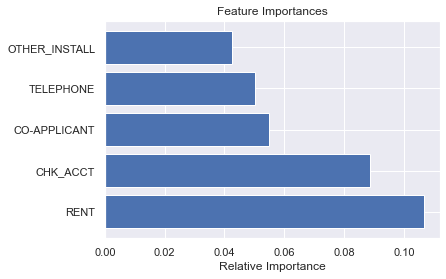

In [91]:
 model = pipe.steps[1][1]
 n_pcs= model.components_.shape[0]
 initial_feature_names = X_train.columns
 most_important = [np.abs(model.components_[i]).argmax() for i in     range(n_pcs)]
 most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
zipped_feats = zip(most_important_names, pipe.steps[2][1].feature_importances_)
 zipped_feats = sorted(zipped_feats, key=lambda x: x[1], reverse=True)
features, importances = zip(*zipped_feats)
 top_features = features[:5]
 top_importances = importances[:5]
plt.title('Feature Importances')
 plt.barh(range(len(top_importances)), top_importances, color='b', align='center')
 plt.yticks(range(len(top_importances)), top_features)
 plt.xlabel('Relative Importance')
 plt.show()

In [99]:
# evaluate RFE for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# create pipeline
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.889 (0.033)


In [101]:
# define dataset
X, y = make_classification(n_samples=1000, n_features=5, n_informative=3, n_redundant=2, random_state=1)
# create pipeline
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.932 (0.021)


In [119]:
# define dataset
X, y = make_classification(n_samples=1000, n_features=5, n_informative=3, n_redundant=2, random_state=1)
# create pipeline
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=5)
model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.889 (0.027)
